<img src="assets/Evaluator-optimizer.png" align="left" width="600" style="margin-right:15px;"/>

In evaluator-optimizer workflows, one LLM call creates a response and the other evaluates that response. If the evaluator or a human-in-the-loop determines the response needs refinement, feedback is provided and the response is recreated. This loop continues until an acceptable response is generated.

In [1]:
from dotenv import load_dotenv, find_dotenv
from env_utils import doublecheck_env
from typing_extensions import Literal
from langchain.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_anthropic import ChatAnthropic

path = find_dotenv()
print("Loaded env from:", path)

# Load environment variables from .env
load_dotenv(find_dotenv())

# Check and print results
doublecheck_env(path)

llm = ChatAnthropic(model="claude-sonnet-4-5-20250929")

Loaded env from: /Users/alien110/Documents/04_Code/Experiments/ex-agents-patterns/langgraph-essentials/python/.env
OPENAI_API_KEY=****EjUA
ANTHROPIC_API_KEY=****wwAA
LANGSMITH_TRACING_V2=true
LANGSMITH_ENDPOINT=****.com
LANGSMITH_API_KEY=****d3f4
LANGSMITH_PROJECT=****-dev


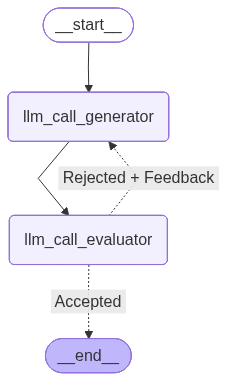

In [4]:
from typing import Annotated, List, Literal
import operator
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langchain_anthropic import ChatAnthropic

# Graph state
class State(TypedDict):
    response: str
    scenario: str
    feedback: str
    quality: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["excellent", "needs improvement"] = Field(
        description="Decide if the customer service response is excellent or needs improvement.",
    )
    feedback: str = Field(
        description="If the response needs improvement, provide specific feedback on how to enhance it for better customer satisfaction and professionalism.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a customer service response"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a professional customer service response for BT to this scenario: {state['scenario']}. Take into account this feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a professional, empathetic customer service response for BT to this scenario: {state['scenario']}")
    return {"response": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the customer service response"""

    grade = evaluator.invoke(f"Evaluate this BT customer service response for professionalism, empathy, and problem-solving: {state['response']}")
    return {"quality": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to response generator or end based upon feedback from the evaluator
def route_response(state: State):
    """Route back to response generator or end based upon feedback from the evaluator"""

    if state["quality"] == "excellent":
        return "Accepted"
    elif state["quality"] == "needs improvement":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_response,
    {  # Name returned by route_response : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
# state = optimizer_workflow.invoke({"scenario": "Customer's broadband has been down for 2 days and they're working from home"})
# print(state["response"])

In [5]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

# Clear cell output
clear_output(wait=True)

# Create all widgets fresh
scenario_input = widgets.Textarea(
    value='Customer is experiencing slow 5G speeds in central London and is frustrated about missing important video calls',
    placeholder='Enter a customer service scenario...',
    description='Scenario:',
    continuous_update=False,
    layout=widgets.Layout(width='600px', height='80px')
)

submit_btn = widgets.Button(
    description='Generate Response',
    button_style='primary',
    icon='comments'
)

result_html = widgets.HTML(value='')

def on_button_click(btn):
    """Handle button click"""
    scenario = scenario_input.value.strip()

    if not scenario:
        result_html.value = "<p>⚠️ Please enter a customer service scenario!</p>"
        return

    # Show loading state
    btn.disabled = True
    result_html.value = f"<p>🔄 Generating customer service response...</p>"

    try:
        # Invoke workflow
        state = optimizer_workflow.invoke({"scenario": scenario})

        # Get the final response and quality
        response = state.get('response', '')
        quality = state.get('quality', '')
        feedback = state.get('feedback', '')

        # Determine quality badge
        if quality == "excellent":
            quality_badge = "<span style='background: #28a745; color: white; padding: 5px 10px; border-radius: 3px; font-weight: bold;'>✓ EXCELLENT</span>"
        else:
            quality_badge = "<span style='background: #ffc107; color: black; padding: 5px 10px; border-radius: 3px; font-weight: bold;'>⚠ NEEDS IMPROVEMENT</span>"

        # Build HTML string with results
        html = f"""
        <div style="font-family: 'Segoe UI', Arial, sans-serif; padding: 20px; background: #f8f9fa; border-radius: 8px;">
            <div style="display: flex; align-items: center; margin-bottom: 15px;">
                <h3 style="color: #5514B4; margin: 0; flex-grow: 1;">BT Customer Service Response Generator</h3>
                {quality_badge}
            </div>
            <hr style="border: 1px solid #5514B4; margin-bottom: 20px;">

            <div style="margin: 20px 0;">
                <h4 style="color: #5514B4; margin-bottom: 10px;">Customer Scenario</h4>
                <div style="background: white; padding: 15px; border-left: 4px solid #5514B4; border-radius: 4px;">
                    <p style="margin: 0; color: #333;">{scenario}</p>
                </div>
            </div>

            <div style="margin: 20px 0;">
                <h4 style="color: #5514B4; margin-bottom: 10px;">Generated Response</h4>
                <div style="background: white; padding: 15px; border-left: 4px solid #28a745; border-radius: 4px;">
                    <div style="white-space: pre-wrap; color: #333;">{response}</div>
                </div>
            </div>

            <div style="margin-top: 20px; padding: 15px; background: #e8f4f8; border-radius: 4px; border-left: 4px solid #0066cc;">
                <h4 style="color: #0066cc; margin-top: 0; margin-bottom: 10px;">Evaluation Results</h4>
                <p style="margin: 5px 0;"><strong>Quality Grade:</strong> {quality}</p>
                {f'<p style="margin: 5px 0;"><strong>Evaluator Feedback:</strong> {feedback}</p>' if feedback else ''}
                <p style="margin: 10px 0 5px 0; font-size: 0.9em; color: #666;"><em>This response was automatically evaluated and refined using an evaluator-optimizer workflow pattern to ensure the highest quality customer service.</em></p>
            </div>
        </div>
        """
        result_html.value = html

    except Exception as e:
        result_html.value = f"<p>❌ Error: {str(e)}</p>"

    finally:
        btn.disabled = False

# Attach handler
submit_btn.on_click(on_button_click)

# Display
display(widgets.VBox([
    widgets.HTML("<h2 style='color: #5514B4;'>🎯 BT Customer Service AI - Evaluator-Optimizer Pattern</h2>"),
    widgets.HTML("""
    <div style="background: #f0f0f0; padding: 15px; border-radius: 5px; margin-bottom: 15px;">
        <h4 style="margin-top: 0;">How This Works:</h4>
        <ol style="margin-bottom: 0;">
            <li><strong>Generator:</strong> AI creates a professional customer service response</li>
            <li><strong>Evaluator:</strong> Another AI evaluates the response for quality, empathy, and professionalism</li>
            <li><strong>Optimizer Loop:</strong> If response needs improvement, feedback is provided and the response is regenerated</li>
            <li><strong>Final Output:</strong> Only excellent responses are approved and delivered</li>
        </ol>
        <p style="margin-bottom: 0;"><strong>Example Scenarios:</strong></p>
        <ul style="margin-top: 5px; margin-bottom: 0;">
            <li>"Customer's fiber broadband installation was missed for the third time"</li>
            <li>"Business customer experiencing intermittent 5G connectivity affecting critical operations"</li>
            <li>"Customer received an unexpectedly high bill and is threatening to switch providers"</li>
            <li>"Smart home devices stopped working after recent network upgrade"</li>
        </ul>
    </div>
    """),
    widgets.HBox([submit_btn]),
    scenario_input,
    result_html
]))